# Transfer Learning with Philippine Languages




In [85]:
!pip -q install accelerate transformers datasets --upgrade

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
import torch
import numpy as np

In [88]:
DEVICE = 'cuda:0'
dev = torch.cuda.get_device_properties(0)
print(f"Using device: {dev.name} ({dev.total_memory/1024/1024/1024:.1f}gb)")

Using device: Tesla T4 (14.7gb)


In [89]:
import torchtext
import datasets
from datasets import DatasetDict, Dataset

In [137]:
path = '/content/drive/MyDrive/filipino_transfer_learning'


torchtext.utils.extract_archive('/content/drive/MyDrive/filipino_transfer_learning/filipino_data.pkl.gz')


['/content/drive/MyDrive/filipino_transfer_learning/filipino_data.pkl']

In [138]:
import pandas as pd

filipino_data = pd.read_pickle("/content/drive/MyDrive/filipino_transfer_learning/filipino_data.pkl.gz")

In [92]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU
    return device

def df_to_tensor(df):
  device = get_device()
  return torch.from_numpy(df.values).float().to(device)

Here I load in the data containing the text data for the 6 languages and then edit it a bit so it can work with the code

In [139]:
from sklearn.model_selection import train_test_split

text_train, text_test, lang_train, lang_test = train_test_split(filipino_data['text'], filipino_data['language'], test_size=0.2, random_state=99)

In [140]:
train = pd.DataFrame([text_train, lang_train]).transpose()
test = pd.DataFrame([text_test, lang_test]).transpose()

In [95]:
import pyarrow as pa
import pyarrow.parquet as pq

In [141]:
train = pa.Table.from_pandas(train)
test = pa.Table.from_pandas(test)

pq.write_table(train, 'filipino-train.parquet')
pq.write_table(test, 'filipino-test.parquet')

In [142]:
ds = DatasetDict({'train':Dataset.from_parquet('filipino-train.parquet'), 'test':Dataset.from_parquet('filipino-test.parquet')})
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/default-591d4f6bbfe44880/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/default-8bc875b3d330bf91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['text', 'language', '__index_level_0__'],
        num_rows: 40446
    })
    test: Dataset({
        features: ['text', 'language', '__index_level_0__'],
        num_rows: 10112
    })
})

Here I set up the transformer libraries and other things I will use.

The model I decided to go with was DistilBERT since it was one of the main ones we used in class

In [98]:
import warnings
import torch
import torchtext

from transformers import AutoTokenizer, pipeline
from datasets import DatasetDict, Dataset

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from transformers import AutoTokenizer, AutoModel, pipeline
from sklearn.linear_model import SGDClassifier

In [99]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [100]:
model = AutoModel.from_pretrained('distilbert-base-uncased').to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Here I built a classifier using contextual word vectors and use that for the model

In [101]:
def vectorize(batch):
  toks = tokenizer(batch['text'], padding="max_length", truncation=True, return_tensors='pt')
  inputs = {k:toks[k].to(DEVICE) for k in tokenizer.model_input_names}
  with torch.no_grad():
    with torch.autocast(device_type='cuda'):
      vec = model(**inputs).last_hidden_state
  return {'vector': vec[:,0].cpu().numpy()}

In [143]:
v = vectorize(ds['train'][:10])

In [165]:
small = DatasetDict({'train': ds['train'].select(range(5000)),
                     'test': ds['test']})

In [166]:
small = small.map(vectorize, batched=True, batch_size=256)

In [167]:
small.save_to_disk('language-vecs')
!zip -r language-vecs.zip language-vecs/

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10112 [00:00<?, ? examples/s]

updating: language-vecs/ (stored 0%)
updating: language-vecs/dataset_dict.json (stored 0%)
updating: language-vecs/train/ (stored 0%)
updating: language-vecs/train/dataset_info.json (deflated 61%)
updating: language-vecs/train/data-00000-of-00001.arrow (deflated 11%)
updating: language-vecs/train/state.json (deflated 38%)
updating: language-vecs/test/ (stored 0%)
updating: language-vecs/test/dataset_info.json (deflated 61%)
updating: language-vecs/test/data-00000-of-00001.arrow (deflated 11%)
updating: language-vecs/test/state.json (deflated 37%)


In [168]:
sgd = SGDClassifier(alpha=0.01)
sgd.fit(small['train']['vector'], small['train']['language'])

SGDClassifier(alpha=0.01)

In [169]:
predict = sgd.predict(small['test']['vector'])
print(classification_report(small['test']['language'], predict))

                       precision    recall  f1-score   support

     bikol literature       0.70      0.70      0.70       993
      bikol religious       0.86      0.11      0.20        54
   cebuano literature       0.94      0.04      0.08       692
    cebuano religious       0.85      0.69      0.76      1066
hiligaynon literature       0.55      0.80      0.65       991
 hiligaynon religious       0.69      0.23      0.34       380
   ilokano literature       0.82      0.75      0.78       886
    ilokano religious       0.67      0.76      0.71       751
   tagalog literature       0.71      0.73      0.72       838
    tagalog religious       0.62      0.74      0.67       435
     waray literature       0.67      0.90      0.77      2102
      waray religious       0.96      0.82      0.88       924

             accuracy                           0.71     10112
            macro avg       0.75      0.61      0.61     10112
         weighted avg       0.74      0.71      0.68 

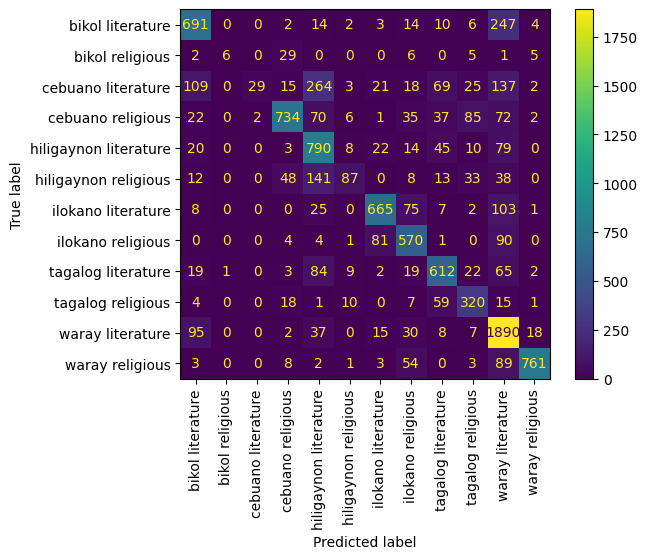

In [175]:
ConfusionMatrixDisplay.from_predictions(small['test']['language'], predict, xticks_rotation=90)

In [170]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [171]:
sgd = SGDClassifier()

search = GridSearchCV(sgd, param_grid={'alpha':[1e-10,1e-8,1e-6,1e-4,1e-3,1e-2,1e-1,1]}, n_jobs=-1)
search.fit(small['train']['vector'], small['train']['language'])
search.best_params_

{'alpha': 0.001}

In [172]:
sgd.set_params(**search.best_params_)
sgd.fit(small['train']['vector'], small['train']['language'])
sgd_predicted = sgd.predict(small['test']['vector'])
print(classification_report(small['test']['language'], sgd_predicted))

                       precision    recall  f1-score   support

     bikol literature       0.71      0.81      0.76       993
      bikol religious       0.58      0.98      0.73        54
   cebuano literature       0.66      0.53      0.59       692
    cebuano religious       0.74      0.85      0.79      1066
hiligaynon literature       0.76      0.80      0.78       991
 hiligaynon religious       0.81      0.59      0.69       380
   ilokano literature       0.77      0.86      0.81       886
    ilokano religious       0.75      0.82      0.78       751
   tagalog literature       0.82      0.78      0.80       838
    tagalog religious       0.98      0.63      0.77       435
     waray literature       0.85      0.83      0.84      2102
      waray religious       0.97      0.88      0.92       924

             accuracy                           0.79     10112
            macro avg       0.78      0.78      0.77     10112
         weighted avg       0.80      0.79      0.79 

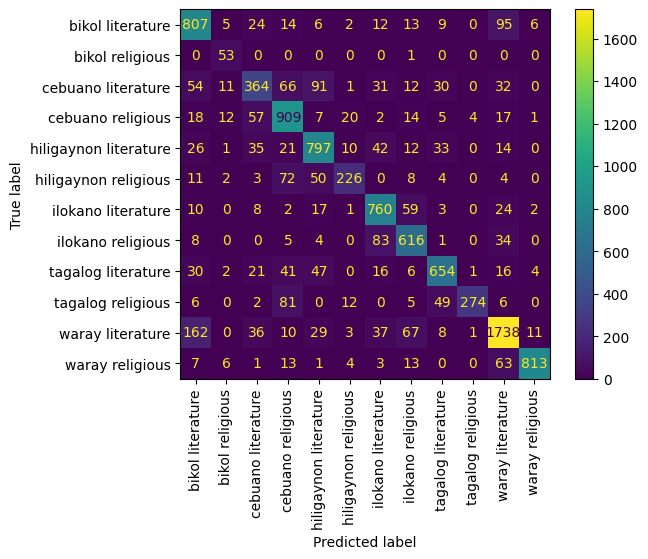

In [173]:
ConfusionMatrixDisplay.from_predictions(small['test']['language'], sgd_predicted, xticks_rotation=90)